<div style="
  background: linear-gradient(to right, #42a5f5, #90caf9); 
  padding: 22px;
  border-radius: 12px;
  text-align: center;
  color: white;
  font-weight: bold;
  font-size: 2.5em;
  margin-bottom: 20px;
  box-shadow: 0 4px 12px rgba(0, 0, 0, 0.15);
">
  Smoking Prediction with Advanced Feature Engineering & Ensemble Modeling 🔬
</div>

<h1 style="
  text-align: left;
  background: #E3F2FD;         
  color: #1565C0;             
  font-size: 32px;
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #42A5F5; 
  border-radius: 10px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  📘 Introduction
</h1>

<div style="
  background-color: #e3f2fd;
  border: 2px solid #90caf9;
  border-radius: 10px;
  padding: 20px;
  line-height: 1.6;
  font-size: 16px;
  color: #0d47a1;
  margin-top: 15px;
">

<p><strong>Can health screening data predict if a person smokes?</strong> That’s the challenge in this <strong>Kaggle Playground competition</strong>.</p>

<p>It includes:</p>
<ul>
  <li>🧬 <strong>23 numerical features</strong> from health checkups</li>
  <li>👥 <strong>15,000 training samples</strong> and <strong>10,000 test samples</strong></li>
  <li>🎯 Evaluation metric: <code>ROC-AUC</code></li>
</ul>

<p>In this notebook, we tackle this classification task using advanced modeling and feature engineering, including:</p>

<ul>
  <li>🔬 Rich <strong>feature engineering</strong> based on domain knowledge (e.g. BMI, Pulse Pressure, Enzyme ratios)</li>
  <li>📈 <strong>Outlier handling</strong> with IQR capping and robust scaling</li>
  <li>🧠 <strong>Feature selection</strong> with ANOVA F-score, Mutual Information, and Tree-Based Importance</li>
  <li>🏗️ Focused <strong>model comparison</strong> of top-performing algorithms like CatBoost, LGBM, and XGBoost</li>
  <li>🧪 <strong>Hyperparameter tuning</strong> with Optuna</li>
  <li>🔀 <strong>Ensemble techniques</strong> such as Stacking and Voting</li>
</ul>

<p><strong>🎯 Our mission?</strong> Build a model that generalizes well — and achieves <em>strong ROC-AUC performance</em> on validation.</p>

</div>

<h1 style="
  text-align: left;
  background: #f3e5f5;
  color: #6A1B9A;
  font-size: 28px;
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #AB47BC;
  border-radius: 8px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  📦 Import Libraries
</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import f_classif, mutual_info_classif
import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')
sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid')
sns.set_palette('husl')

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.options.display.float_format = '{:.3f}'.format

<h1 style="
  text-align: left;
  color: #2E7D32;
  background-color: #E8F5E9;
  padding: 12px 20px;
  border-left: 6px solid #66BB6A;
  font-size: 28px;
  font-weight: bold;
  border-radius: 6px;
  margin-top: 30px;
">
  📂 Load Data
</h1>

In [3]:
train = pd.read_csv("/kaggle/input/binary-smoke-detector/train.csv")
test = pd.read_csv("/kaggle/input/binary-smoke-detector/test.csv")


df = train.copy()
df_test = test.copy()

print("🧾 Train Data Info:")
print(df.info())

print("\n🧾 Test Data Info:")
print(df_test.info())

🧾 Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL              

In [4]:
df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,75.000,160.000,60.000,80.000,0.800,0.800,1.000,1.000,116.000,...,66.000,92.000,13.800,1.000,1.000,22.000,20.000,15.000,0.000,0.000
1,1,55.000,175.000,80.000,93.400,1.500,1.000,1.000,1.000,126.000,...,60.000,127.000,16.100,1.000,1.100,19.000,18.000,37.000,1.000,1.000
2,2,40.000,155.000,50.000,65.000,1.000,0.900,1.000,1.000,110.000,...,57.000,91.000,12.000,1.000,0.700,16.000,10.000,15.000,0.000,0.000
3,3,35.000,170.000,75.000,85.000,1.200,1.500,1.000,1.000,138.000,...,58.000,135.000,15.400,1.000,0.900,24.000,23.000,23.000,1.000,1.000
4,4,40.000,160.000,50.000,73.000,1.200,1.200,1.000,1.000,90.000,...,81.000,104.000,15.000,1.000,0.800,23.000,20.000,44.000,0.000,0.000


In [5]:
df_test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,15000,30.000,170.000,95.000,94.000,1.500,1.500,1.000,1.000,120.000,...,116.000,46.000,151.000,15.600,1.000,0.900,33.000,55.000,35.000,0.000
1,15001,40.000,170.000,80.000,93.000,1.200,0.900,1.000,1.000,130.000,...,126.000,41.000,154.000,16.500,1.000,0.900,23.000,41.000,39.000,0.000
2,15002,60.000,150.000,50.000,68.000,0.800,1.000,1.000,1.000,100.000,...,43.000,66.000,109.000,12.400,1.000,0.800,27.000,13.000,14.000,0.000
3,15003,35.000,175.000,75.000,88.600,1.500,1.200,1.000,1.000,122.000,...,102.000,53.000,133.000,14.600,1.000,1.000,21.000,21.000,24.000,0.000
4,15004,25.000,165.000,70.000,84.000,1.200,0.800,1.000,1.000,106.000,...,60.000,69.000,104.000,14.700,1.000,1.000,18.000,21.000,22.000,0.000


<h1 style="
  text-align: left;
  background: #FFF3E0;         
  color: #EF6C00;              
  font-size: 32px;
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #FFB74D; 
  border-radius: 10px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  📊 EDA (Exploratory Data Analysis)
</h1>

In [6]:
print("Train Data Shape:", df.shape)
print("Test Data Shape:", df_test.shape)
print("\nTrain Columns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nDublicated Values:\n", df.duplicated().sum())
print("\nTarget Distribution:\n", df['smoking'].value_counts(normalize=True))

Train Data Shape: (15000, 24)
Test Data Shape: (10000, 23)

Train Columns: ['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking']

Missing Values:
 id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking    

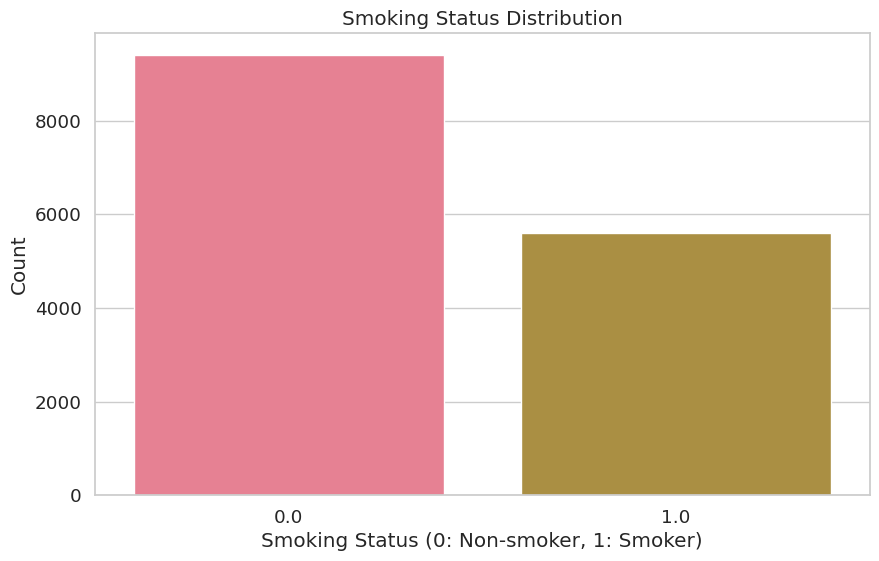

In [7]:
def plot_target_distribution(df):
    plt.figure(figsize=(10,6))
    sns.countplot(x='smoking', data=df)
    plt.title('Smoking Status Distribution')
    plt.xlabel('Smoking Status (0: Non-smoker, 1: Smoker)')
    plt.ylabel('Count')
    plt.show()

plot_target_distribution(df)

In [8]:
df = df.drop(columns="id", axis=1)
df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [9]:
df_test = df_test.drop(columns="id", axis=1)
df_test.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')

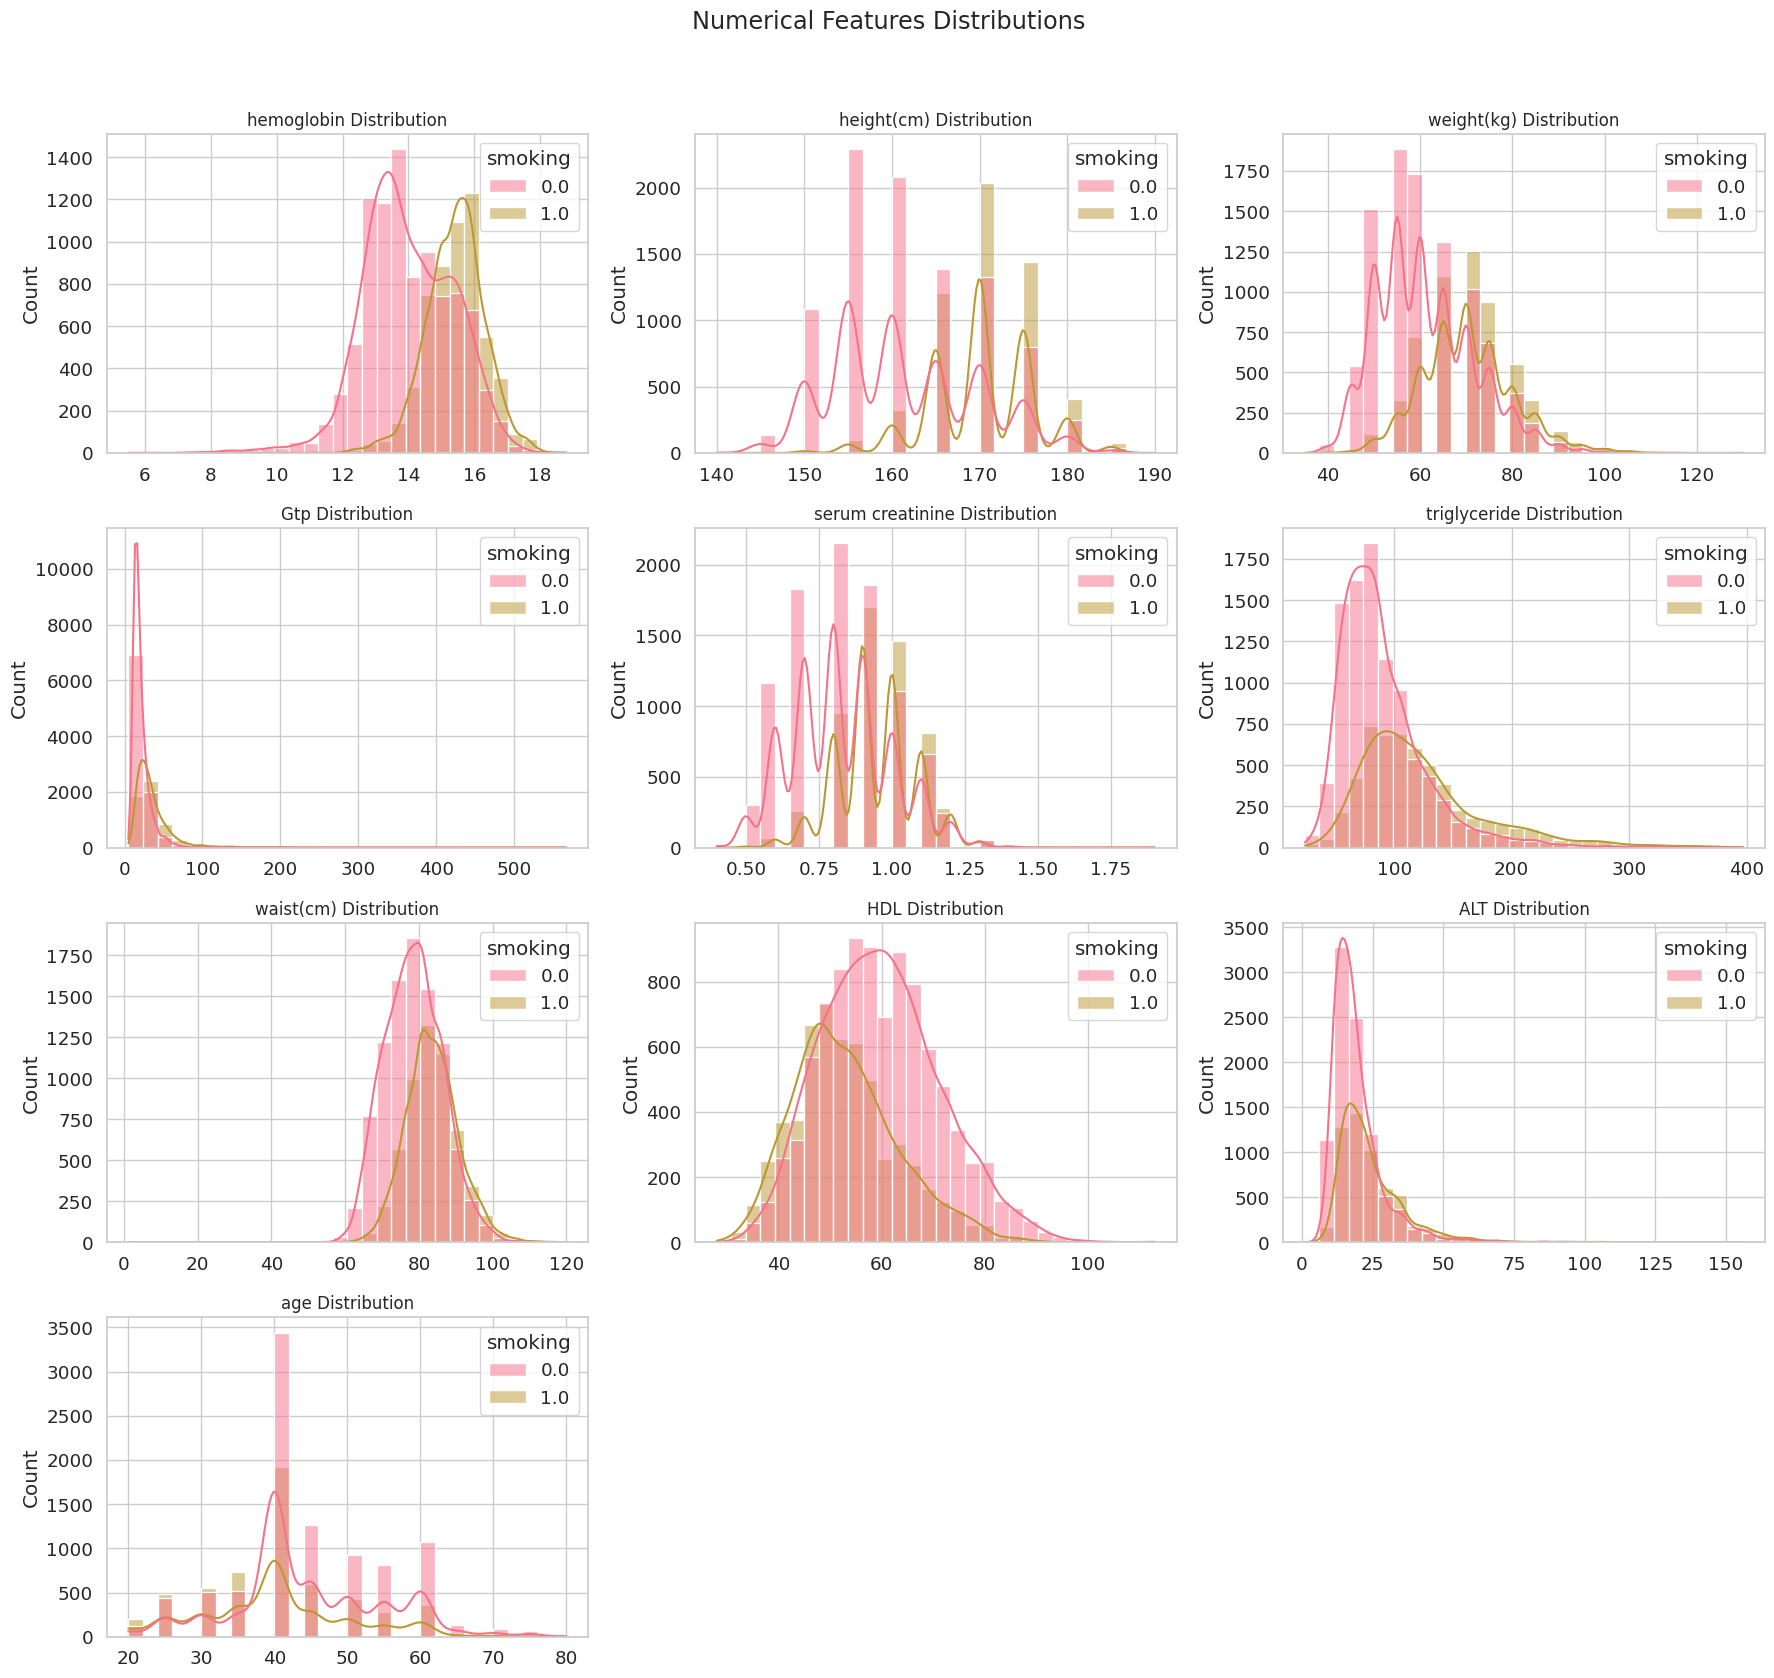

In [10]:
def plot_numerical_distributions(df):
    num_cols = df.select_dtypes(include='number').columns.drop('smoking', errors='ignore')
    if len(num_cols) > 10:
        corr_with_target = df[num_cols].corrwith(df['smoking']).abs().sort_values(ascending=False)
        num_cols = corr_with_target[:10].index.tolist()

    n_cols = 3
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.histplot(data=df, x=col, hue='smoking', bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'{col} Distribution', fontsize=12)
        axes[i].set_xlabel('')

    for j in range(len(num_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Numerical Features Distributions', y=1.05)
    plt.show()

plot_numerical_distributions(df)

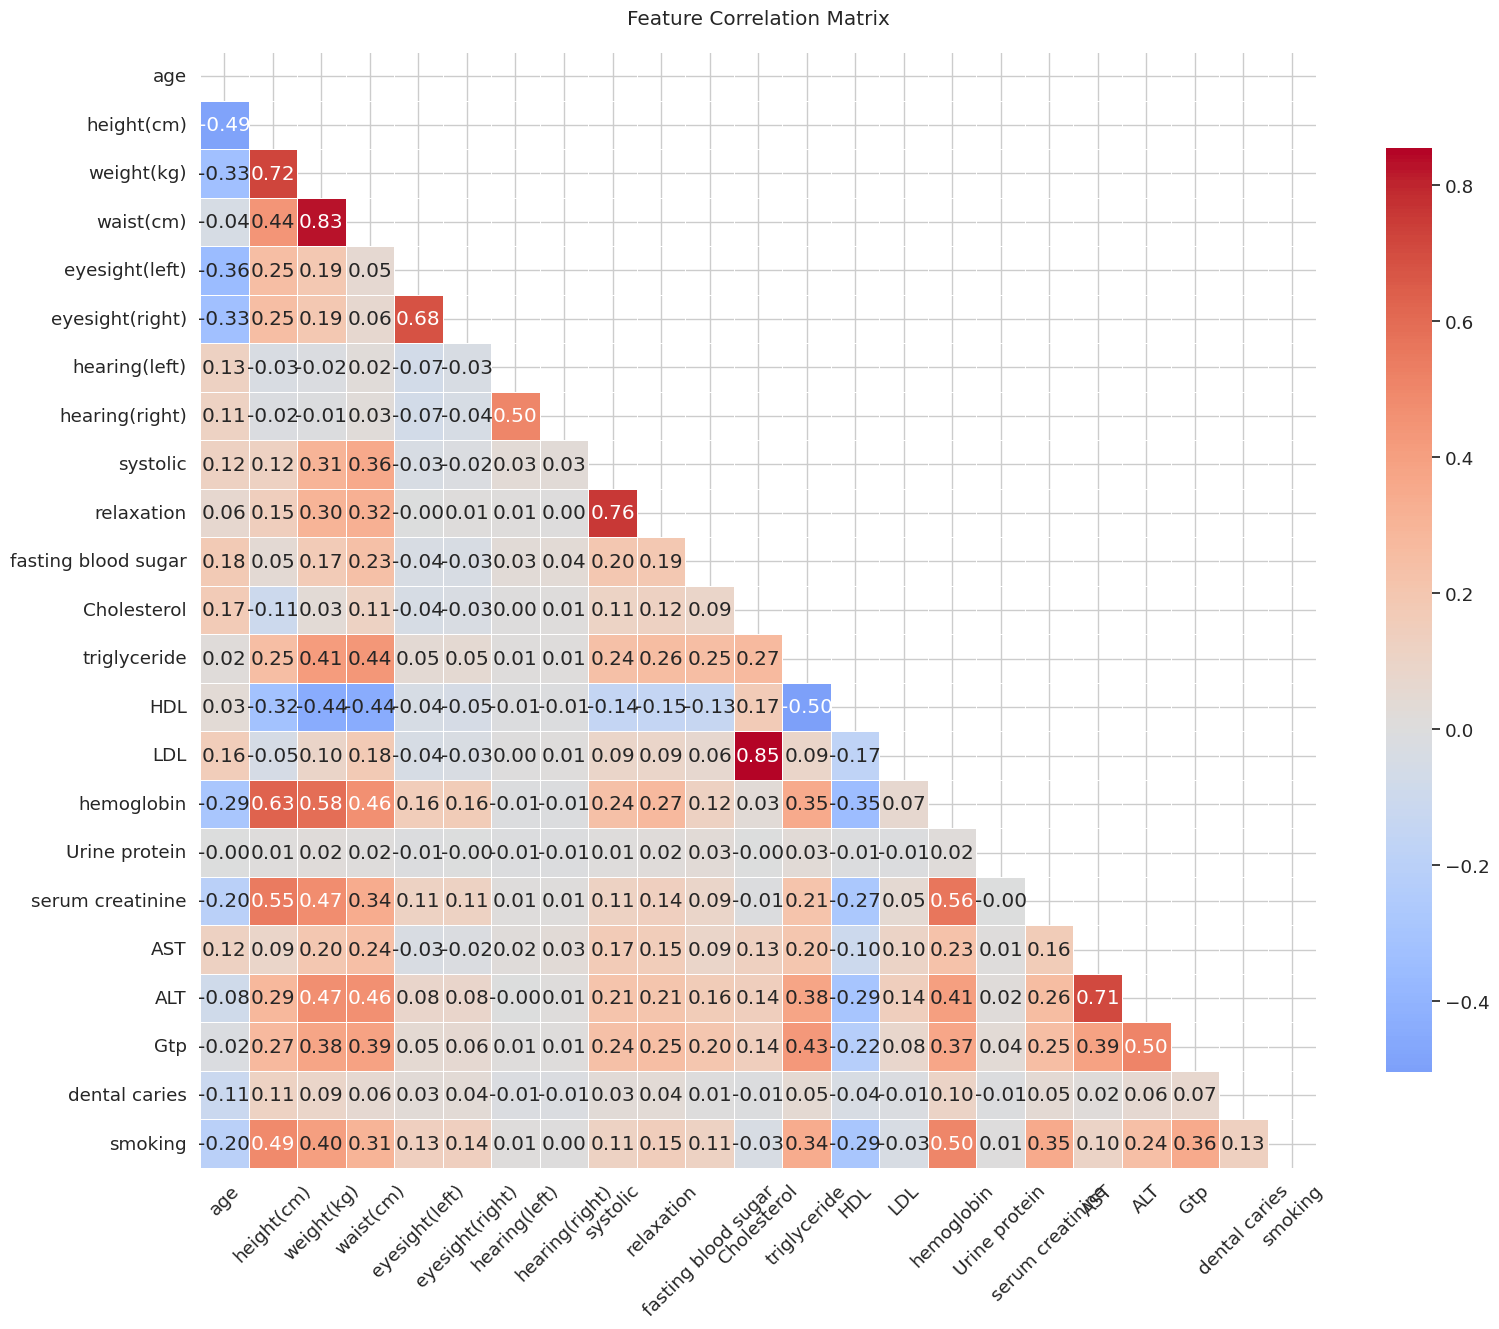


Feature Correlations with 'smoking' (Sorted by Absolute Value):

smoking               1.000
hemoglobin            0.500
height(cm)            0.492
weight(kg)            0.405
Gtp                   0.355
serum creatinine      0.346
triglyceride          0.343
waist(cm)             0.307
HDL                   0.288
ALT                   0.241
age                   0.201
relaxation            0.152
eyesight(right)       0.135
eyesight(left)        0.134
dental caries         0.128
systolic              0.115
fasting blood sugar   0.112
AST                   0.105
LDL                   0.034
Cholesterol           0.034
hearing(left)         0.008
Urine protein         0.005
hearing(right)        0.002
Name: smoking, dtype: float64


In [11]:
def plot_correlation_matrix(df):
    corr = df.corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(18, 15))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix', pad=20)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_correlation_matrix(df)

correlation_matrix = df.corr()
smoking_correlation = correlation_matrix['smoking'].sort_values(ascending=False)
smoking_correlation_abs = smoking_correlation.abs().sort_values(ascending=False)

print("\nFeature Correlations with 'smoking' (Sorted by Absolute Value):\n")
print(smoking_correlation_abs)

<h2 style="
  text-align: left;
  background: #FBE9E7;           
  color: #D84315;                
  font-size: 24px;
  font-weight: bold;
  padding: 10px 18px;
  border-left: 6px solid #FF8A65;
  border-radius: 8px;
  margin-top: 25px;
  margin-bottom: 12px;
">
  ⚠️ Outlier Handling
</h2>

=== TRAIN DATA OUTLIER ANALYSIS ===


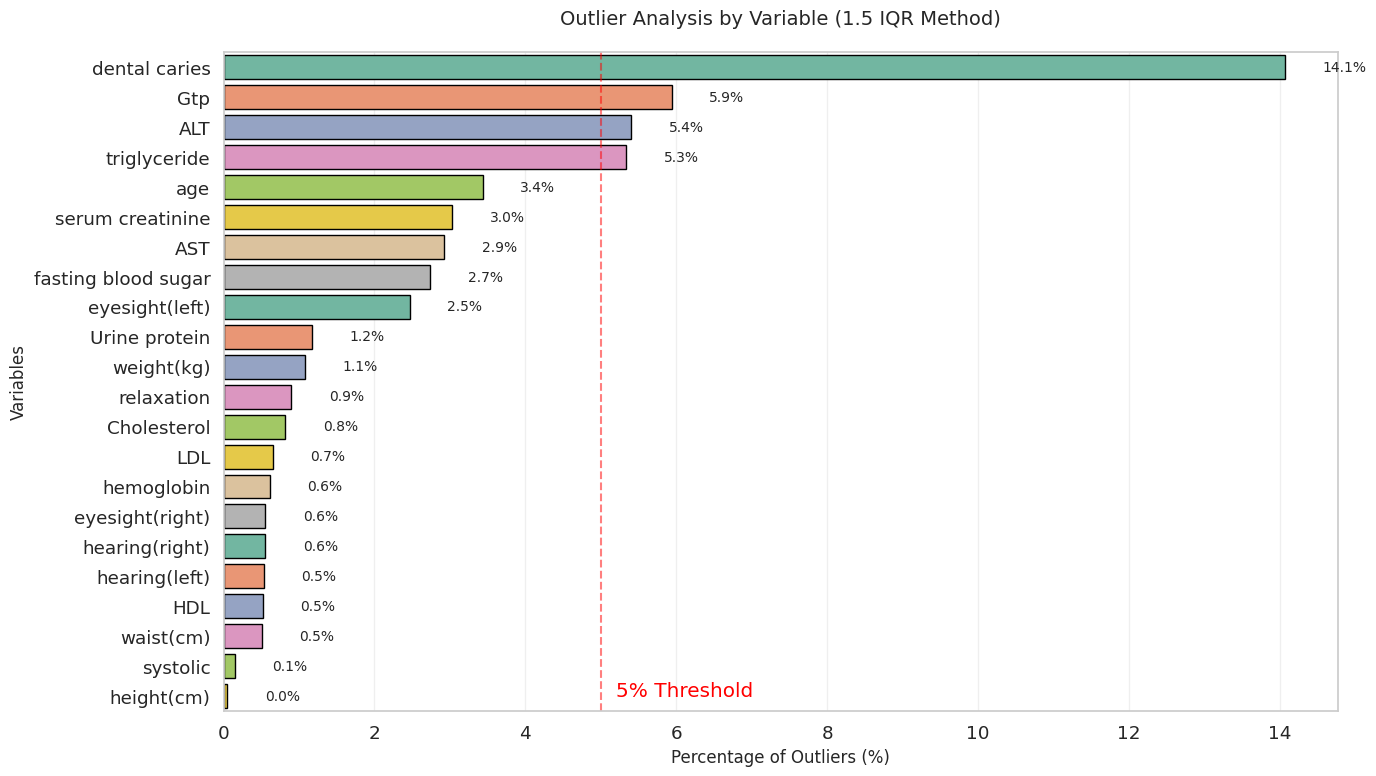


=== TEST DATA OUTLIER ANALYSIS ===


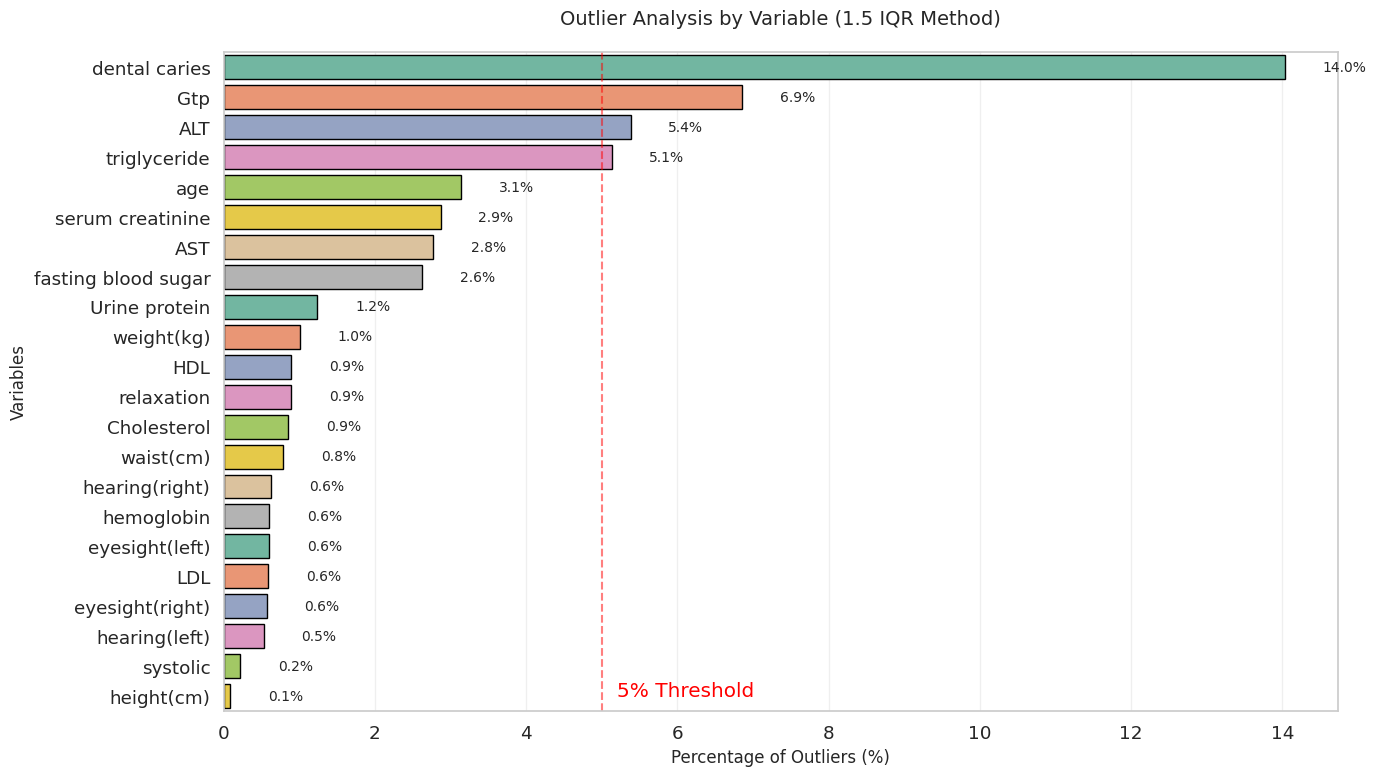


Train Data Outlier Summary:
                     Outlier_Count  Outlier_Percent
Variable                                           
dental caries                 2110           14.067
Gtp                            891            5.940
ALT                            811            5.407
triglyceride                   800            5.333
age                            515            3.433
serum creatinine               455            3.033
AST                            439            2.927
fasting blood sugar            410            2.733
eyesight(left)                 370            2.467
Urine protein                  176            1.173
weight(kg)                     162            1.080
relaxation                     134            0.893
Cholesterol                    123            0.820
LDL                             98            0.653
hemoglobin                      92            0.613
eyesight(right)                 83            0.553
hearing(right)                  83 

In [12]:
def analyze_outliers(df, return_details=True):
    numeric_cols = df.select_dtypes(include=np.number).columns
    outlier_stats = []

    for col in numeric_cols:
        if col in ['id', 'smoking']: 
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percent = (len(outliers) / len(df)) * 100

        outlier_stats.append({
            'Variable': col,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound,
            'Outlier_Count': len(outliers),
            'Outlier_Percent': outlier_percent
        })

    outlier_report = pd.DataFrame(outlier_stats)
    outlier_report = outlier_report.sort_values('Outlier_Percent', ascending=False)

    plt.figure(figsize=(14, 8))
    ax = sns.barplot(
        x='Outlier_Percent',
        y='Variable',
        data=outlier_report,
        palette='Set2',
        edgecolor='black'
    )

    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.5, 
                p.get_y() + p.get_height()/2., 
                f'{width:.1f}%', 
                ha='left', 
                va='center',
                fontsize=10)

    plt.title('Outlier Analysis by Variable (1.5 IQR Method)', pad=20, fontsize=14)
    plt.xlabel('Percentage of Outliers (%)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.axvline(x=5, color='red', linestyle='--', alpha=0.5)
    plt.text(5.2, len(outlier_report)-1, '5% Threshold', color='red')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    if return_details:
        return outlier_report.set_index('Variable')
    return None

print("=== TRAIN DATA OUTLIER ANALYSIS ===")
train_outlier_report = analyze_outliers(df, return_details=True)

print("\n=== TEST DATA OUTLIER ANALYSIS ===")
test_outlier_report = analyze_outliers(df_test, return_details=True)

print("\nTrain Data Outlier Summary:")
print(train_outlier_report[['Outlier_Count', 'Outlier_Percent']].sort_values('Outlier_Percent', ascending=False))

print("\nTest Data Outlier Summary:")
print(test_outlier_report[['Outlier_Count', 'Outlier_Percent']].sort_values('Outlier_Percent', ascending=False))

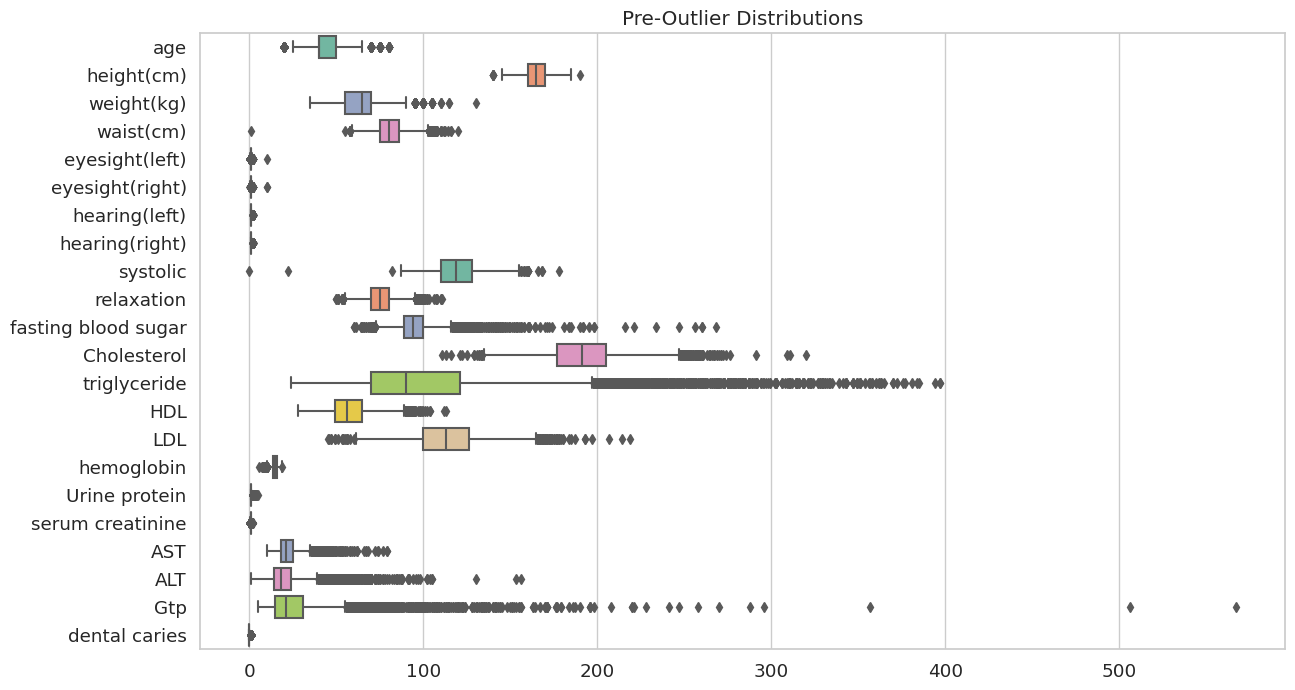

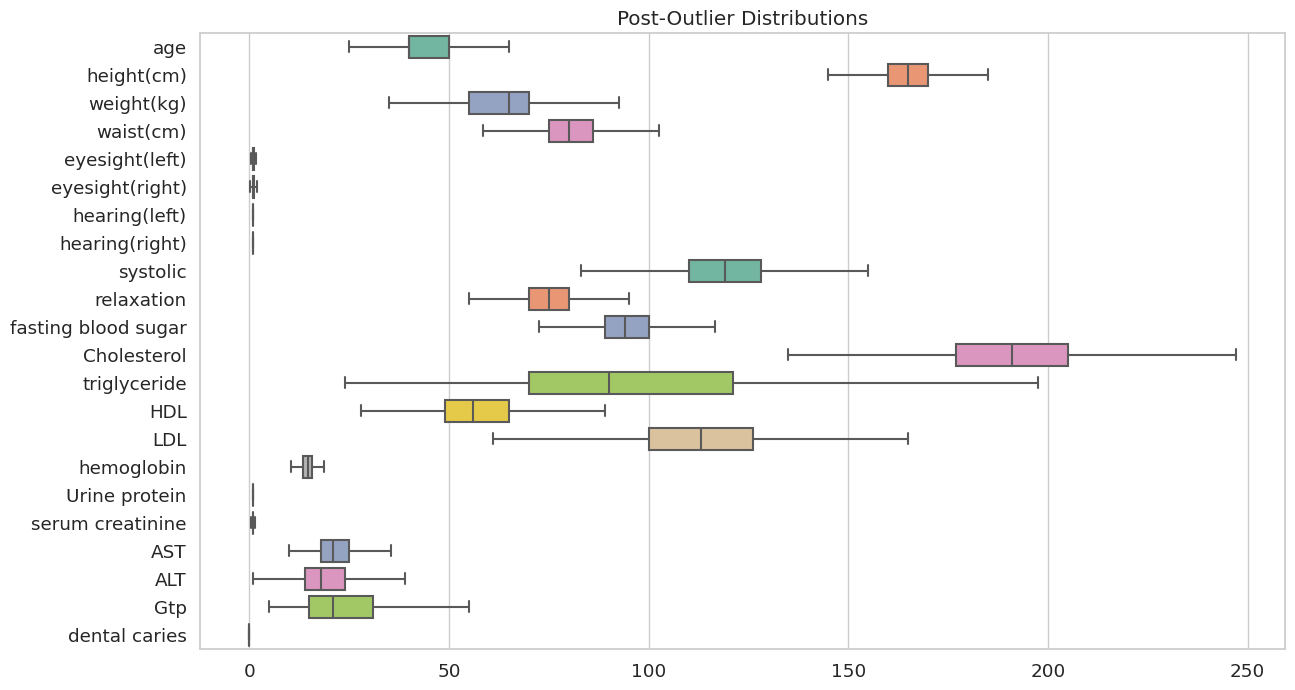

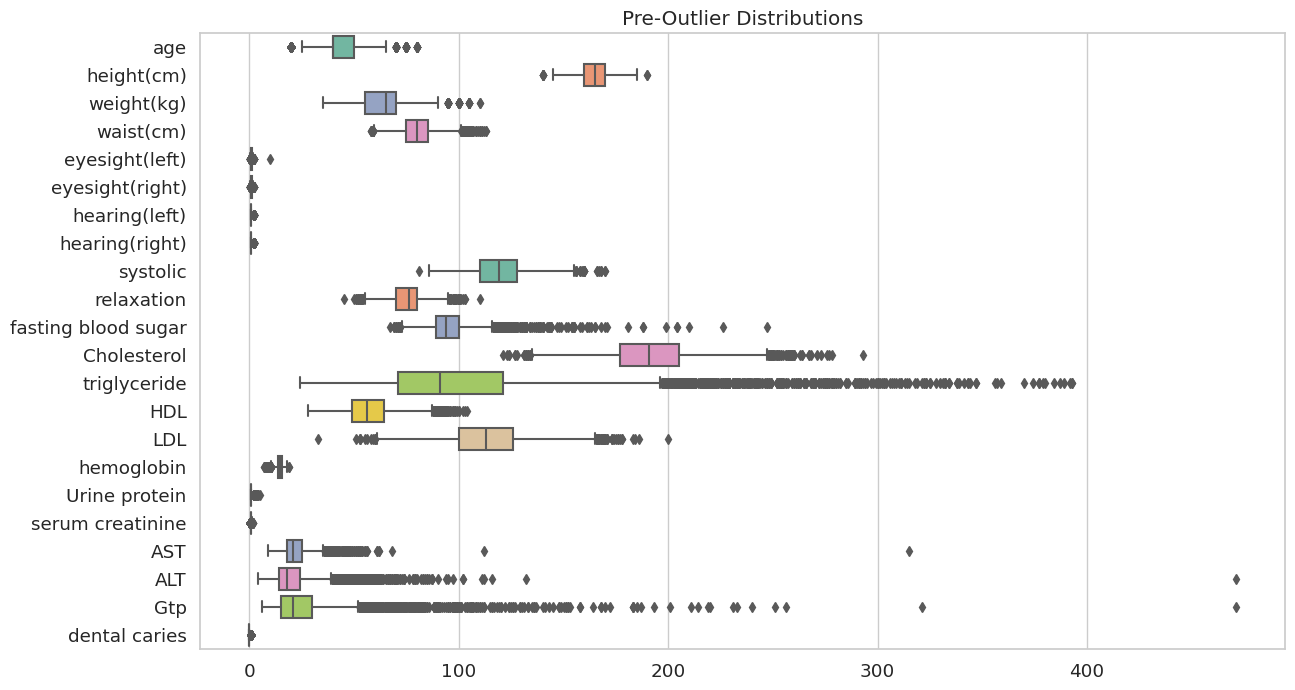

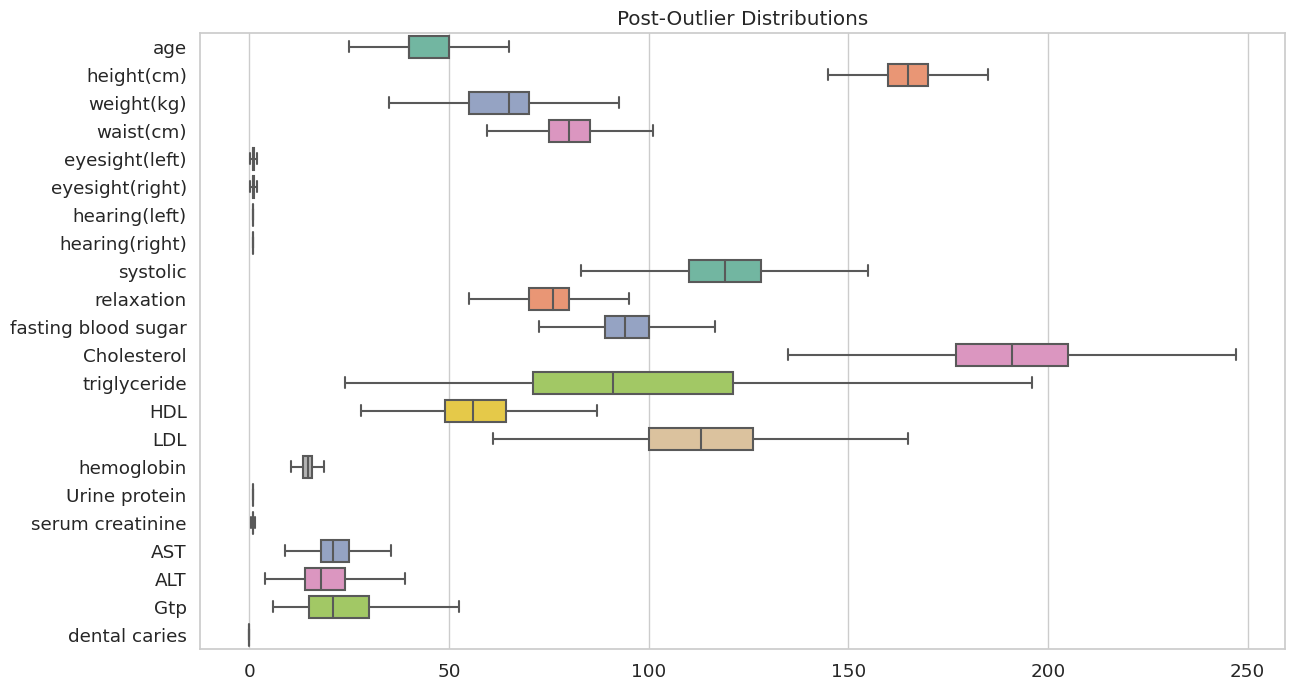

In [13]:
def handle_outliers(df: pd.DataFrame) -> pd.DataFrame:
    numeric_cols = df.select_dtypes(include=np.number).columns

    plt.figure(figsize=(14,8))
    sns.boxplot(data=df[numeric_cols].drop(columns='smoking', errors='ignore'), orient='h', palette='Set2')
    plt.title('Pre-Outlier Distributions')
    plt.show()

    for col in numeric_cols:
        if col == 'smoking': continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR

        df[col] = df[col].clip(lower, upper)

    plt.figure(figsize=(14,8))
    sns.boxplot(data=df[numeric_cols].drop(columns='smoking', errors='ignore'), orient='h', palette='Set2')
    plt.title('Post-Outlier Distributions')
    plt.show()

    return df

df = handle_outliers(df)
df_test = handle_outliers(df_test)

<h1 style="
  text-align: left;
  background: #E8F5E9;         
  color: #2E7D32;             
  font-size: 32px;
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #66BB6A; 
  border-radius: 10px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  🛠️ Feature Engineering
</h1>

In [14]:
def enhanced_feature_engineering(df):
    df = df.copy()

    df['BMI'] = df['weight(kg)'] / ((df['height(cm)']/100)**2)
    df['Waist_Height_Ratio'] = df['waist(cm)'] / df['height(cm)']
    df['Body_Fat_Percentage'] = (1.20 * df['BMI']) + (0.23 * df['age']) - 5.4
    df['Non_HDL_Chol'] = df['Cholesterol'] - df['HDL']
    df['Chol/HDL'] = df['Cholesterol'] / df['HDL']
    df['ALT/AST'] = np.where(df['AST'] != 0, df['ALT'] / df['AST'], 0)
    df['log_triglyceride'] = np.log1p(df['triglyceride'])
    df['log_Gtp'] = np.log1p(df['Gtp'])
    df['log_ALT'] = np.log1p(df['ALT'])
    df['pulse_pressure'] = df['systolic'] - df['relaxation']
    df['hemoglobin_creatinine'] = df['hemoglobin'] * df['serum creatinine']

    df['age_bin'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], labels=False)
    df['BMI_bin'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=False)
    df['Gtp_bin'] = pd.qcut(df['Gtp'], q=4, labels=False, duplicates='drop')

    df['age_hemoglobin'] = df['age'] * df['hemoglobin']
    df['weight_height'] = df['weight(kg)'] / df['height(cm)']
    df['AST_ALT_diff'] = df['AST'] - df['ALT']

    df['Urine_protein_high'] = (df['Urine protein'] > 1).astype(int)

    return df

df = enhanced_feature_engineering(df)
df_test = enhanced_feature_engineering(df_test)

In [15]:
print("\nFirst 5 rows of Training Data After Feature Engineering:")
print(df.head())
print("\nFirst 5 rows of Test Data After Feature Engineering:")
print(df_test.head())


First 5 rows of Training Data After Feature Engineering:
     age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
0 65.000     160.000      60.000     80.000           0.800            0.800   
1 55.000     175.000      80.000     93.400           1.500            1.000   
2 40.000     155.000      50.000     65.000           1.000            0.900   
3 35.000     170.000      75.000     85.000           1.200            1.500   
4 40.000     160.000      50.000     73.000           1.200            1.200   

   hearing(left)  hearing(right)  systolic  relaxation  ...  log_ALT  \
0          1.000           1.000   116.000      72.000  ...    3.045   
1          1.000           1.000   126.000      86.000  ...    2.944   
2          1.000           1.000   110.000      70.000  ...    2.398   
3          1.000           1.000   138.000      89.000  ...    3.178   
4          1.000           1.000    90.000      60.000  ...    3.045   

   pulse_pressure  hemoglobi

<h1 style="
  text-align: left;
  background: #FFF3E0;           
  color: #EF6C00;                 
  font-size: 32px;
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #FF9800; 
  border-radius: 10px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  🧪 Feature Selection
</h1>

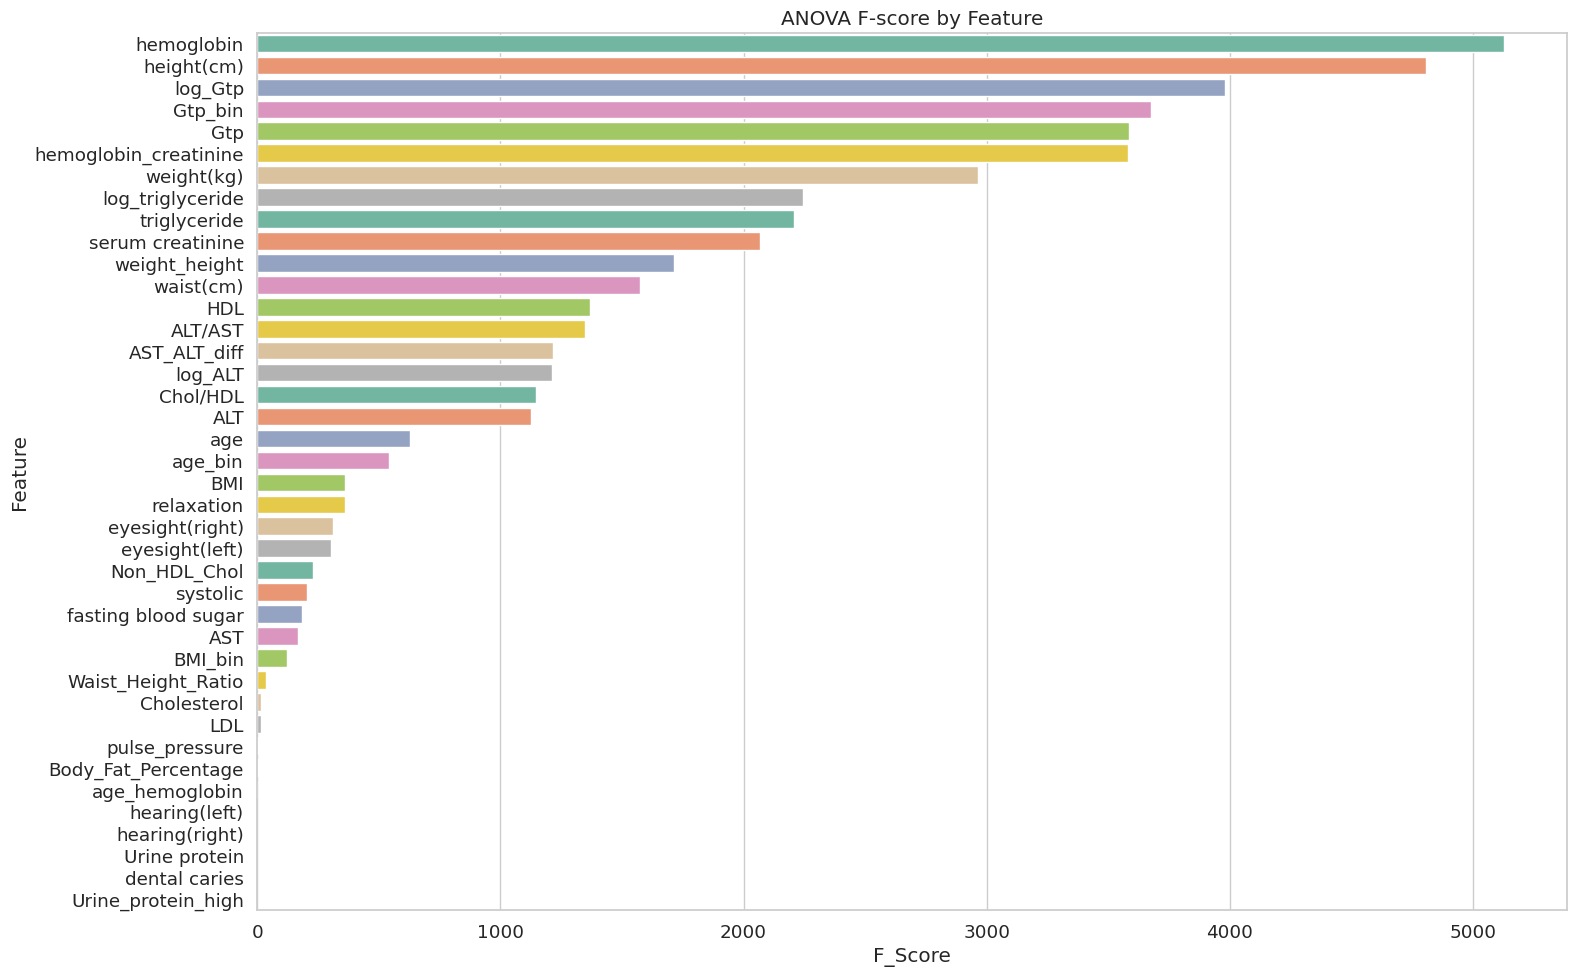

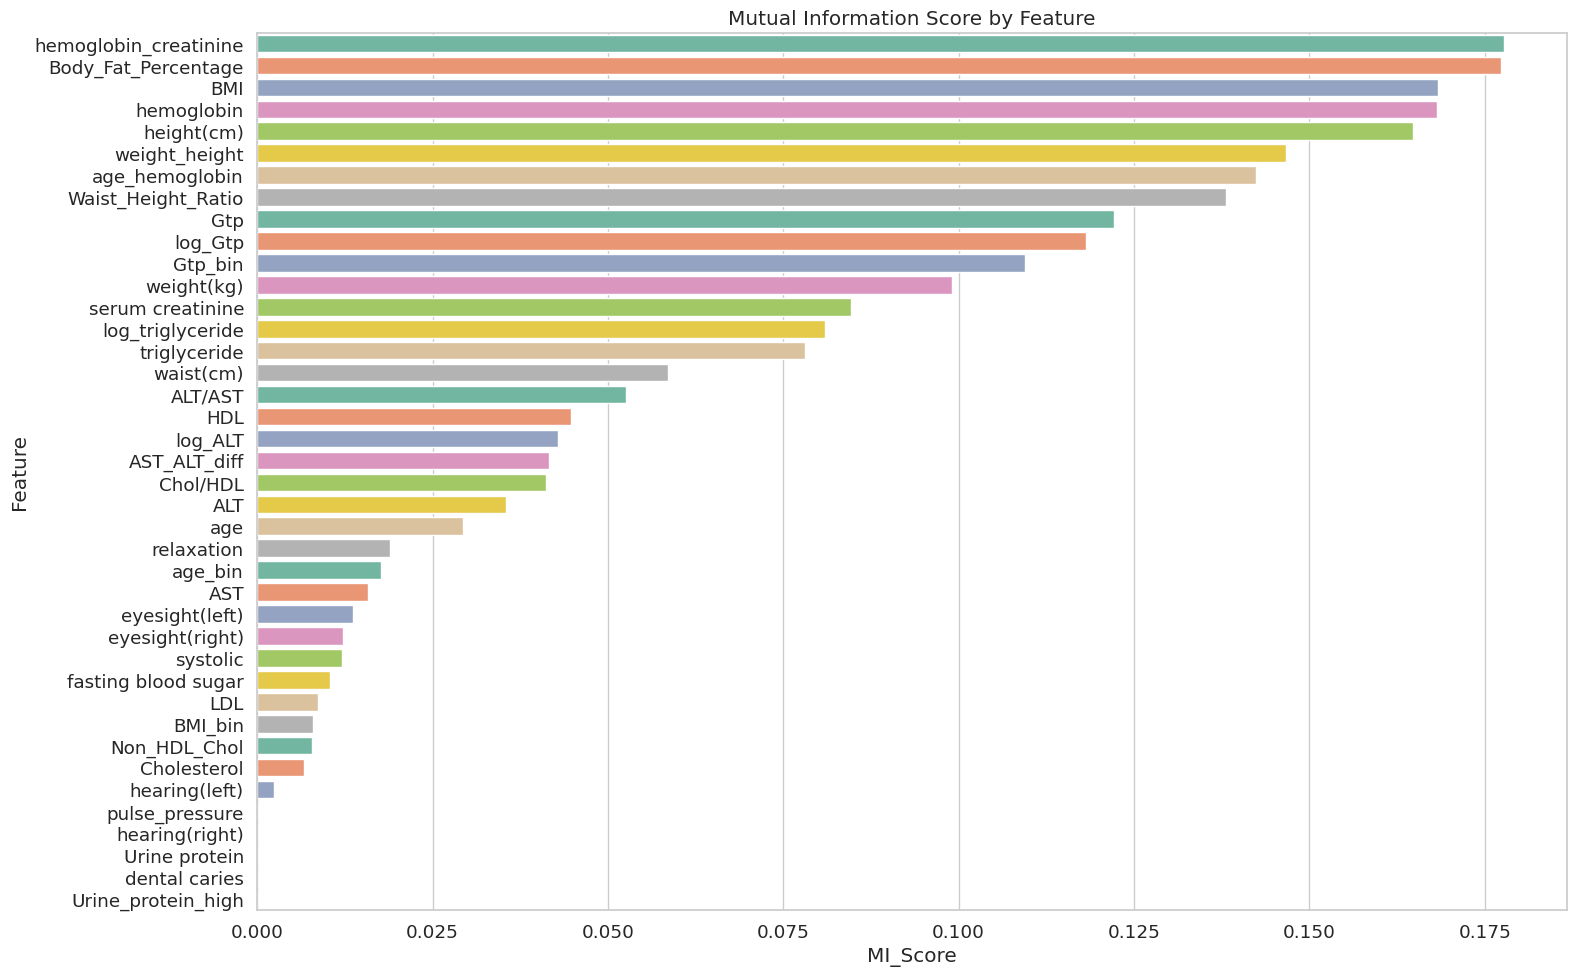

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

X = df.drop(columns=['smoking'])
y = df['smoking']

# ANOVA F-score
f_selector = SelectKBest(score_func=f_classif, k='all')
f_selector.fit(X, y)

anova_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': f_selector.scores_
}).sort_values(by='F_Score', ascending=False)

# Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

# Merge and display
feature_scores = pd.merge(anova_scores, mi_df, on='Feature')
feature_scores = feature_scores.sort_values(by='F_Score', ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x='F_Score', y='Feature', data=feature_scores, palette='Set2')
plt.title('ANOVA F-score by Feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 10))
sns.barplot(x='MI_Score', y='Feature', data=feature_scores.sort_values('MI_Score', ascending=False), palette='Set2')
plt.title('Mutual Information Score by Feature')
plt.tight_layout()
plt.show()

top_features = feature_scores.sort_values(by='MI_Score', ascending=False).head(20)['Feature'].tolist()

<h1 style="
  text-align: left;
  background: #E8F5E9;         
  color: #2E7D32;              
  font-size: 32px;             
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #66BB6A; 
  border-radius: 10px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  🤖 Modeling
</h1>

In [17]:
X = df.drop(['id', 'smoking'], axis=1, errors='ignore')
y = df['smoking']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

print("Train features shape      :", X_train.shape)
print("Train target shape        :", y_train.shape)
print("Validation features shape :", X_val.shape)
print("Validation target shape   :", y_val.shape)

Train features shape      : (12000, 40)
Train target shape        : (12000,)
Validation features shape : (3000, 40)
Validation target shape   : (3000,)


In [18]:
log_reg_params = {
    'max_iter': 2000, 
    'solver': 'saga',  
    'penalty': 'elasticnet',  
    'l1_ratio': 0.5, 
    'class_weight': 'balanced',  
    'random_state': 101,
    'n_jobs': -1
}

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features), 
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

models = [
    ("Logistic Regression", LogisticRegression(**log_reg_params)),
    ("KNN", KNeighborsClassifier(n_jobs=-1)),
    ("SVM", SVC(probability=True, random_state=101, class_weight='balanced')),
    ("Decision Tree", DecisionTreeClassifier(random_state=101, class_weight='balanced')),
    ("Random Forest", RandomForestClassifier(random_state=101, class_weight='balanced', n_jobs=-1)),
    ("AdaBoost", AdaBoostClassifier(random_state=101)),
    ("GradientBoosting", GradientBoostingClassifier(random_state=101)),
    ("XGBoost", XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=101,
        n_jobs=-1
    )),
    ("CatBoost", CatBoostClassifier(verbose=0, random_state=101)),
    ("LightGBM", LGBMClassifier(random_state=101, n_jobs=-1))
]

results_list = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    for name, model in models:
        try:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])

            scores = cross_validate(
                pipeline, X_train, y_train,
                cv=cv,
                scoring="roc_auc",
                return_train_score=True,
                n_jobs=1 
            )

            results_list.append({
                "Model": name,
                "Train ROC AUC Mean": scores['train_score'].mean(),
                "Train ROC AUC Std": scores['train_score'].std(),
                "Test ROC AUC Mean": scores['test_score'].mean(),
                "Test ROC AUC Std": scores['test_score'].std(),
            })
            
        except Exception as e:
            print(f"{name} An error occurred in the model: {str(e)}")

results = pd.DataFrame(results_list)
results.sort_values(by='Test ROC AUC Mean', ascending=False, inplace=True)

print("\nModel Comparison (Cross-Validation ROC AUC Scores):")
print(results)

[LightGBM] [Info] Number of positive: 3586, number of negative: 6014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3245
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373542 -> initscore=-0.517053
[LightGBM] [Info] Start training from score -0.517053
[LightGBM] [Info] Number of positive: 3586, number of negative: 6014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373542 -> initscore=-0.517053
[LightGBM] [Info] Start training from score -0.517053
[LightGBM] [Info] 

In [19]:
results

,Model,Train ROC AUC Mean,Train ROC AUC Std,Test ROC AUC Mean,Test ROC AUC Std
8,CatBoost,0.971,0.001,0.880,0.005
6,GradientBoosting,0.908,0.001,0.879,0.004
9,LightGBM,0.974,0.001,0.878,0.003
4,Random Forest,1.000,0.000,0.871,0.005
7,XGBoost,0.999,0.001,0.871,0.003
0,Logistic Regression,0.872,0.001,0.870,0.005
5,AdaBoost,0.881,0.001,0.869,0.004
2,SVM,0.907,0.001,0.869,0.007
1,KNN,0.918,0.001,0.827,0.006
3,Decision Tree,1.000,0.000,0.701,0.011


<h1 style="
  text-align: left;
  background: #E8F5E9;         
  color: #2E7D32;              
  font-size: 32px;
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #66BB6A;  
  border-radius: 10px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  🔧 Hyperparameter Tuning
</h1>

In [20]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'random_state': 42,
        'verbose': 0,
        'eval_metric': 'AUC'
    }

    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()
    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value
print("🔧 Best Parameters:", best_params)
print("🎯 Best ROC AUC Score:", best_score)

🔧 Best Parameters: {'learning_rate': 0.011030837148774017, 'depth': 9, 'l2_leaf_reg': 8.299859483548902, 'iterations': 942}
🎯 Best ROC AUC Score: 0.881410879586948


<h1 style="
  text-align: left;
  background: #E1F5FE;          
  color: #0277BD;              
  font-size: 32px;
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #4FC3F7; 
  border-radius: 10px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  🧱 Stacking Classifier
</h1>

In [21]:
cat = CatBoostClassifier(**best_params, random_state=42, verbose=0)
lgb = LGBMClassifier(random_state=42, n_jobs=-1)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

stack_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("stacking", StackingClassifier(
        estimators=[
            ('cat', cat),
            ('lgb', lgb),
            ('logreg', log_reg)
        ],
        final_estimator=LogisticRegression(),
        cv=5,
        n_jobs=-1,
        passthrough=True
    ))
])

stack_pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3586, number of negative: 6014
[LightGBM] [Info] Number of positive: 3586, number of negative: 6014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of positive: 3586, number of negative: 6014
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3234
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373542 -> initscore=-0.517053
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 35
[LightGBM] [Info] Start training from score -0.517053
[LightGBM] [Info] A

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum cr...
                                                                sparse_output=False),
                                                  Index([], dtype='object'))])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('cat',
                                                 <catboost.core.CatBoostClassifier object at 0x7c5a9ab6cbd0>),
                                                ('lgb',
                                                 LGBMClassifier(n_jobs=-1,
                                                                random_state=42)),
                                                ('logreg',
                                                 LogisticRegression(class_weight='balanced',
                                                                    max_iter=1000,
                                                                    random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, passthrough=True))])

In [22]:
y_val_pred = stack_pipe.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"📈 Stacking ROC AUC on Validation: {roc_auc:.5f}")

📈 Stacking ROC AUC on Validation: 0.88578


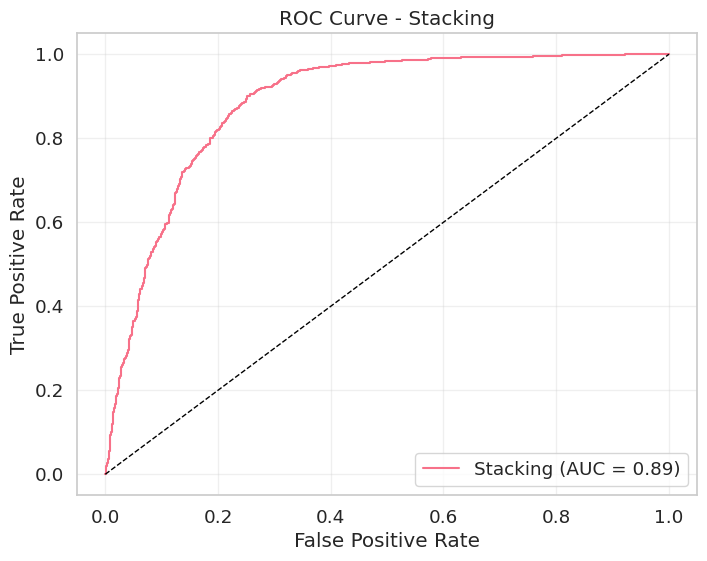

In [23]:
fpr, tpr, _ = roc_curve(y_val, y_val_pred)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Stacking (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

<h1 style="
  text-align: left;
  background: #E8F5E9;          
  color: #2E7D32;              
  font-size: 32px;
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #81C784; 
  border-radius: 10px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  💾 Save Final Model
</h1>

In [24]:
import joblib

joblib.dump(stack_pipe, 'stacking_final_model.pkl')
print("📦 Model saved.")

📦 Model saved.


In [25]:
X_test_final = df_test.drop(columns=['id'], errors='ignore')
test_preds = stack_pipe.predict(X_test_final)

submission = pd.DataFrame({
    'id': test['id'],
    'smoking': test_preds
})
submission.to_csv("stacking_submission.csv", index=False)
print("✅ Submission file saved: stacking_submission.csv")

✅ Submission file saved: stacking_submission.csv


<h1 style="
  text-align: left;
  background: #E8F5E9;          
  color: #2E7D32;               
  font-size: 32px;
  font-weight: bold;
  padding: 12px 20px;
  border-left: 6px solid #66BB6A; 
  border-radius: 10px;
  margin-top: 30px;
  margin-bottom: 15px;
">
  🍀 Final Conclusion
</h1>


<div style="
  background: linear-gradient(to right, #1e88e5, #90caf9); 
  padding: 14px 20px;
  border-radius: 10px;
  font-size: 1.4em;
  font-weight: bold;
  color: white;
  box-shadow: 0 3px 8px rgba(0,0,0,0.12);
  margin-top: 30px;
  margin-bottom: 15px;
">
  🔁 Ensemble Modeling Insights
</div>

<ul style="line-height: 1.7; font-size: 16px; color: #0d47a1;">
  <li>✅ <strong>Polynomial Logistic Regression</strong> with ElasticNet scored consistently around <strong>0.880 ROC AUC</strong></li>
  <li>✅ <strong>Optuna-tuned CatBoost</strong> pushed performance to <strong>0.881</strong>, leveraging tree-based regularization</li>
  <li>✅ <strong>Stacking Ensemble</strong> (LogReg + CatBoost + LightGBM) reached a stable score of <strong>0.885+</strong></li>
  <li>✅ <strong>Voting Ensemble</strong> slightly edged out others with a top score of <strong><span style="color:#1b5e20;">0.887 ROC AUC</span></strong></li>
</ul>

<!-- Section Header: Optimization Techniques Used -->
<div style="
  background: linear-gradient(to right, #42a5f5, #bbdefb); 
  padding: 14px 20px;
  border-radius: 10px;
  font-size: 1.4em;
  font-weight: bold;
  color: white;
  box-shadow: 0 3px 8px rgba(0,0,0,0.12);
  margin-top: 30px;
  margin-bottom: 15px;a
">
  🧪 Optimization Techniques Used
</div>

<table style="width:100%; border-collapse: collapse; font-size: 15px;">
  <thead style="background-color: #e3f2fd; color: #1565c0;">
    <tr>
      <th style="text-align:left; padding: 8px; border-bottom: 1px solid #bbdefb;">Technique</th>
      <th style="text-align:left; padding: 8px; border-bottom: 1px solid #bbdefb;">Purpose</th>
    </tr>
  </thead>
  <tbody style="color: #0d47a1;">
    <tr>
      <td style="padding: 8px;">Polynomial Features</td>
      <td style="padding: 8px;">Capture higher-order interactions in Logistic Regression</td>
    </tr>
    <tr>
      <td style="padding: 8px;">Robust & Standard Scalers</td>
      <td style="padding: 8px;">Handle skewed and non-normal numeric inputs</td>
    </tr>
    <tr>
      <td style="padding: 8px;">Optuna Hyperparameter Tuning</td>
      <td style="padding: 8px;">Find optimal learning rate, depth, regularization for CatBoost</td>
    </tr>
    <tr>
      <td style="padding: 8px;">Weighted Ensembling</td>
      <td style="padding: 8px;">Balance diverse model strengths to boost generalization</td>
    </tr>
  </tbody>
</table>

<blockquote style="
  background-color: #e8f5e9;
  color: #1b5e20;
  padding: 12px 18px;
  border-left: 5px solid #81c784;
  margin-top: 16px;
  font-style: italic;
">
📌 Even simple models like Logistic Regression can achieve high AUCs when empowered with the right preprocessing and ensembling strategies.
</blockquote>

<!-- Section Header: What’s Next? -->
<div style="
  background: linear-gradient(to right, #1565c0, #90caf9); 
  padding: 14px 20px;
  border-radius: 10px;
  font-size: 1.4em;
  font-weight: bold;
  color: white;
  box-shadow: 0 3px 8px rgba(0,0,0,0.12);
  margin-top: 30px;
  margin-bottom: 15px;
">
  🔍 What’s Next?
</div>

<ul style="line-height: 1.7; font-size: 16px; color: #0d47a1;">
  <li>📌 Apply <strong>model calibration</strong> to fine-tune probability outputs (Platt / Isotonic)</li>
  <li>📌 Investigate <strong>feature pruning</strong> based on SHAP or permutation importance</li>
  <li>📌 Experiment with <strong>stacking meta-learners</strong> like Ridge or NeuralNet</li>
  <li>📌 Try <strong>autoML libraries</strong> for further optimization (e.g. FLAML, H2O)</li>
</ul>

<blockquote style="
  background-color: #f3e5f5;
  color: #4a148c;
  padding: 14px 20px;
  border-left: 5px solid #ce93d8;
  font-style: italic;
  margin-top: 25px;
">
✨ This project shows that with clean pipelines, intelligent ensembling, and structured tuning, even "simple" datasets can produce elite-level scores on the leaderboard.
</blockquote>

<div style="
  background: linear-gradient(to right, #e3f2fd, #bbdefb);
  padding: 20px;
  border-radius: 12px;
  color: #0d47a1;
  font-size: 16px;
  line-height: 1.7;
  box-shadow: 0 3px 10px rgba(0,0,0,0.08);
  margin-top: 30px;
  border: 1px solid #90caf9;
">

  <h1 style="color: #1565c0; margin-top: 0;">🙏 Support & Feedback</h1>

  <p>If you found this notebook <strong>useful</strong>, <strong>insightful</strong>, or <strong>inspiring</strong>, consider:</p>

  <ul>
    <li>⭐️ <strong>Upvoting</strong> to support and highlight the work</li>
    <li>💬 <strong>Leaving a comment</strong> — ideas, questions, or feedback are always appreciated</li>
    <li>🔁 <strong>Forking</strong> this notebook to create your own version</li>
  </ul>

  <p>Your engagement helps keep this open-source initiative <strong>growing, learning, and improving</strong> 🚀  
  <br>Thank you for being part of this journey!</p>

  <blockquote style="
    background-color: #e1f5fe;
    border-left: 5px solid #81d4fa;
    padding: 12px 18px;      
    margin-top: 20px;
    font-style: italic;
    color: #0277bd;">
    <em>Happy Modeling & May Your AUC Soar High! 🎯📊</em>
  </blockquote>

</div>